# Tensorboard Introduction

In this tutorial, we’ll learn how to:

1. Set up TensorBoard;
2. Write something to TensorBoard, e.g. images;
3. Inspect a model architecture using TensorBoard;
4. Train model and write loss, accuracy and some images to TensorBoard;
5. Play with different weight initialization techniques in TensorBoard.

## 0. Short Introduction about TensorBoard

In machine learning, to improve something you often need to be able to measure it. TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

You can download TensorBoard by simply running the following command in terminal:

In [1]:
!pip install tensorboard==2.0 > /dev/null

In [2]:
import tensorboard
print(f"Tensorboard version: {tensorboard.__version__}")
if not tensorboard.__version__.startswith("2.0"):
    print("You are using an another version of Tensorboard. We expect Tensorboard 2.0.0. You can continue with your version but it"
          " might cause some issues")

Tensorboard version: 2.0.0


Note that version of your tensorboard module should match your torch version, and you may find all blank after logging into the TensorBoard site if the versions mismatch. If such error occurs, you may try the following command to download tensorboad with specific **VERSION_NUMBER** you want:

```pip install tensorboard==VERSION_NUMBER```

Section 1 to 4 in this tutorial are highly aligned with the official tutorial，which is very clear and straighforward, you may also check and play with it in coLab：

https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html


## 1. TensorBoard Setup

Let's load dataset and define our simple network from the pytorch intro notebook to train.


In [3]:
# imports
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])  # mean and std have to be sequences (e.g. tuples),
                                                                      # therefore we should add a comma after the values

fashion_mnist_dataset = torchvision.datasets.FashionMNIST(root='../datasets', train=True,
                                                          download=True, transform=transform)

fashion_mnist_test_dataset = torchvision.datasets.FashionMNIST(root='../datasets', train=False,
                                                          download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(fashion_mnist_dataset, batch_size=8)

testloader = torch.utils.data.DataLoader(fashion_mnist_test_dataset, batch_size=8)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.cpu().mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:

class Net(nn.Module):
    def __init__(self, activation=nn.Sigmoid(),
                 input_size=1*28*28, hidden_size=100, classes=10):
        super(Net, self).__init__()
        self.input_size = input_size

        # Here we initialize our activation and set up our two linear layers
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, classes)

    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return x
    
net = Net()
net.to(device)

Net(
  (activation): Sigmoid()
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

After loading the dataset and setting up the model we want to train, we now import tensorboard from utils and define a **SummaryWriter**, which will be a working station for us later to log and visualize data we want during training. 

In the following example, we will create a folder called **runs/introduction** to save SummaryWriter and later log into TensorBoard through terminal Command.

In [6]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/introduction')

## 2. Write to TensorBoard

Let's write some stuff to TensorBoard, and log into it to see how things go :)
You can log into TensorBoard by running the command from this exercise folder in Terminal:

```tensorboard --logdir=runs```

For Linux user, you can use open a Terminal and simply run it

For Windows user with Anaconda, you may open an Anaconda Prompt and then run the command. Otherwise use your default setup of running python code in cmd.

Note that before running the command **you may get into root folder of this Notebook first**. Finally from the command line and then navigating to http://localhost:6006. If everything went well you will be presented with the tensorboard stup and after executing the next cell you should see the following images in TensorBoard.


![tensorBoard Interface](./images/imgvis.jpg)


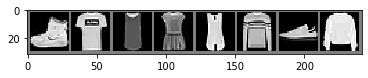

In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)

# write to tensorboard
writer.add_image('four_mnist_images', img_grid)

You might need to hit the refresh button on the top right as tensorboard will only update in intervals.

## 3. Model Architecture visualization in TensorBoard

You can also visualize the architecture of your model in Tensorboard. Let's see how the input and output dimensions of your model look like TensorBoard. It is also a good way to debug as your model growing more and more complex. You may see the following output after adding the graph of network architecture to the TensorBoard.

![Model Architecture Visualization](./images/net_graph.jpg)


In [8]:
writer.add_graph(net.cpu(), images)
writer.close()

Click the 'GRAPHS' section in the top ribbon to access it and play a bit. The above image was generated by clicking on our network.

## 4. Train Model with TensorBoard

Now let's explore one of the most important use of TensorBoard in model training, that is, tracking the loss and accuracy every some iterations. Now, we’ll instead log the running loss to TensorBoard, along with a view into the predictions the model is making via the plot_classes_preds function.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

Finally, let’s start training the model and writing results to TensorBoard every 1000 batches instead of printing to console; this is done using the **add_scalar** function. 

In addition, as we train, we’ll generate an image showing the model’s predictions vs. the actual results on the four images included in that batch.

In [12]:
epochs = 2
running_loss = 0.0
net.to(device)

for epoch in range(epochs):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...
            print("[Epoch %d, Iteration %5d]" % (epoch+1, i+1))

            # ...log the running loss
            writer.add_scalar('Training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('Predictions vs Actuals',
                            plot_classes_preds(net, inputs, labels),
                            i)
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Iteration  1000]
[Epoch 1, Iteration  2000]
[Epoch 1, Iteration  3000]
[Epoch 1, Iteration  4000]
[Epoch 1, Iteration  5000]
[Epoch 1, Iteration  6000]
[Epoch 1, Iteration  7000]
[Epoch 2, Iteration  1000]
[Epoch 2, Iteration  2000]
[Epoch 2, Iteration  3000]
[Epoch 2, Iteration  4000]
[Epoch 2, Iteration  5000]
[Epoch 2, Iteration  6000]
[Epoch 2, Iteration  7000]
Finished Training


Instead of a printing output here in the notebook, you will see the current loss log in Tensorboard under 'SCALARS' in more or less real time. We also generated a prediction image for you under 'IMAGES'.

## 5. Visualization of Weight Initialization Effect

You should now be already familier with some basic writing functions in TensorBoard. Let's explore the effect weight initialization using TensorBoard, and here we will also use **add_historgram** function to visualize the output distribution of each layer.

In previous exercises we used a naive Gaussian initialization, though in the lectures you learned that one needs to be careful about the type of weight initialization. In addition, it is reliant on your activation function of choice. Let's replicate those experiments!

We write all important information to Tensorboard, so check your results there after every cell.

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/weighit_init_experiments')

Let's define a dummy network and keep track of the output of each layer.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, activation_method):
        super(Net, self).__init__()
        
        self.x1 = torch.Tensor([])
        self.x2 = torch.Tensor([])
        self.x3 = torch.Tensor([])
        self.x4 = torch.Tensor([])
        self.x5 = torch.Tensor([])
        self.x6 = torch.Tensor([])
                
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 300)
        self.fc4 = nn.Linear(300, 300)
        self.fc5 = nn.Linear(300, 300)
        self.fc6 = nn.Linear(300, 300)
        self.fc7 = nn.Linear(300, 10)
        
        if activation_method == "relu" :
            self.activation = nn.ReLU() 
        elif activation_method == "tanh":
            self.activation = nn.Tanh() 
        
    def forward(self, x):
        x = x.reshape(-1,28*28)
        self.x1 = self.activation(self.fc1(x))
        self.x2 = self.activation(self.fc2(self.x1))
        self.x3 = self.activation(self.fc3(self.x2))
        self.x4 = self.activation(self.fc4(self.x3))
        self.x5 = self.activation(self.fc5(self.x4))
        self.x6 = self.activation(self.fc6(self.x5))
        logits = self.fc7 (self.x6)
        return logits

    def collect_layer_out (self):
        return [self.x1, self.x2, self.x3, self.x4, self.x5, self.x6]

In [15]:
# get some random training images
visloader = torch.utils.data.DataLoader(fashion_mnist_dataset, batch_size=40, shuffle=True)
dataiter = iter(visloader)
images, labels = dataiter.next()

In [16]:
net = Net("tanh")
print(images.size())

torch.Size([40, 1, 28, 28])


## 5.1 Constant weight initialization

Let's start with constant weight initialization, what problems do you observe with the distribution of the output of each layer? 

In [18]:
net_const = Net("tanh")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.constant_(m.weight,2.0)
        m.bias.data.fill_(0.01)
        
net_const.apply(init_weights)
outputs = net_const(images)
layer_out = net_const.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('constant_init', x, i+1)

## 5.2 Small random weight initialization with Tanh

From last example we can see that initialization with constant have problems of weight symmetry, i.e. all parameters in network always learn the same things. So now we will try some random weight initialization and let's see what happens if weights are initialized with high values or very low values.

In [19]:
net_small_normal = Net("tanh")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0.0, std=0.01)
        m.bias.data.fill_(0.01)
        
net_small_normal.apply(init_weights)
outputs = net_small_normal(images)
layer_out = net_small_normal.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('small_normal_tanh', x, i+1)

## 5.3 Large random weight initialization with Tanh

In [20]:
net_large_normal = Net("tanh")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0.0, std=0.2)
        m.bias.data.fill_(0.01)
        
net_large_normal.apply(init_weights)
outputs = net_large_normal(images)
layer_out = net_large_normal.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('large_normal_tanh', x, i+1)

From last two examples, we can see that random weight initialization with normal distribution might work well in some shallow layers of the network, while if we are going deeper into the network, it will end up with **vanishing gradient problem**, i.e.

1) If weights are initialized with very high values the term $Xw+b$ becomes significantly higher and if an activation function like Tanh is applied, the function maps its value near to -1 or 1, where the gradient is very low and learning takes a lot of time.

2) If weights are initialized with low values it gets mapped to around 0,and the rather small values will kill gradients when doing backpropagation. 


## 5.4 Xavier initialization with Tanh

From the previous examples, we can see that a proper weight initialization is a method that will ensure nice distribution of the ouput of each layer. As a result, we may turn to **Xavier Initialization**:

We will fill the weight with values using a normal distribution $\mathcal{N}(0,std^2)$ where

$$ std = gain \times \sqrt{\frac{2}{fan _{in} + fan_{out}}} $$

Note here $fan _{in}$ and $ fan_{out} $ are dimensions of the ipunt and output layer and $gain$ is a optional scaling factor.

In [22]:
net_xavier = Net("tanh")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)
        
net_xavier.apply(init_weights)
outputs = net_xavier(images)
layer_out = net_xavier.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('xavier_tanh', x, i+1)

## 5.5 Xavier initialization with ReLU

However, a zero centered activation function in xavier activation is assumed, and we can see here activations collapse to zero again if we use ReLU as activation function instead.

In [23]:
net_xavier_relu = Net("relu")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
net_xavier_relu.apply(init_weights)
outputs = net_xavier_relu(images)
layer_out = net_xavier_relu.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('xavier_relu', x, i+1)

## 5.6 He initialization with ReLU

Here we may turn to **He Initialization** to resolve the problems of non-centered activation functions.  
We will fill the weight with values using a normal distribution $\mathcal{N}(0,std^2)$ where

$$ std = \frac {gain} {\sqrt{fan_{mode}}} $$

Note here $fan _{mode}$ can be chosen either $fan _{in}$ (default) or $fan _{out}$. Choosing $fan _{in}$ preserves the magnitude of the variance of the weights in the forward pass. Choosing $fan _{out}$ preserves the magnitudes in the backwards pass. and $gain$ is also a optional scaling factor.

In [24]:
net_kaiming_relu = Net("relu")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')
        m.bias.data.fill_(0.01)
        
net_kaiming_relu.apply(init_weights)
outputs = net_kaiming_relu(images)
layer_out = net_kaiming_relu.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('kaiming_relu', x, i+1)

With that, you should have everything at hand to work with Tensorboard. It is highly advised to use either Tensorboard or other similar libraries, such as visdom, instead of implementing everything yourself.